In [49]:
import pickle
import tempfile
import numpy as np
import tensorflow as tf
from get_data import *
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
MAX_SEQ_LEN = 42
EMBEDDING_DIM = 300
VOCAB_SIZE = 20000

In [4]:
data = read_data()
train_data = data[:3]
test_data = data[3:]

In [5]:
train_data, embed_matrix = preprocess_traindata(train_data, MAX_SEQ_LEN, EMBEDDING_DIM, VOCAB_SIZE)

Non labelled: 785
Contradiction: 183187
Neutral: 182764
Entailment: 183416


In [6]:
train_data[0].shape

(549367, 42)

In [7]:
train_data[1].shape

(549367, 42)

In [8]:
train_data[2].shape

(549367, 3)

In [28]:
embedding =  tf.keras.layers.Embedding(embed_matrix.shape[0], output_dim=EMBEDDING_DIM, weights=[embed_matrix], input_length=MAX_SEQ_LEN, trainable=False)

In [29]:
# Define the input layers and its shapes for premise and hypothesis
premise = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')

In [30]:
premise.shape, hypothesis.shape

(TensorShape([None, 42]), TensorShape([None, 42]))

In [31]:
# Embed the premise and hypothesis
premise_embedded = embedding(premise)
hypothesis_embedded = embedding(hypothesis)

In [32]:
premise_embedded.shape, hypothesis_embedded.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [33]:
# Add a time distributed translation layer for better performance
# Time distributed layer applies the same Dense layer to each temporal slice of input
translation = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(300, activation='relu'))

In [34]:
# Apply the translation layer
premise_translated = translation(premise_embedded)
hypothesis_translated = translation(hypothesis_embedded)

In [35]:
premise_translated.shape, hypothesis_translated.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [36]:
# Bidirectional LSTM layer
BiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100))

In [37]:
# Apply the bidirectional LSTM layer
premise_BiLSTM = BiLSTM(premise_translated)
hypothesis_BiLSTM = BiLSTM(hypothesis_translated)

In [38]:
premise_BiLSTM.shape, hypothesis_BiLSTM.shape

(TensorShape([None, 200]), TensorShape([None, 200]))

In [39]:
# Apply Batch normalization
premise_normalized = tf.keras.layers.BatchNormalization()(premise_BiLSTM)
hypothesis_normalized = tf.keras.layers.BatchNormalization()(hypothesis_BiLSTM)

In [40]:
# Concatenate the normalized premise and hypothesis and apply a dropout layer
train_input = tf.keras.layers.concatenate([premise_normalized, hypothesis_normalized])
# train_input = tf.keras.layers.Dropout(0.2)(train_input)

In [41]:
train_input.shape

TensorShape([None, 400])

In [42]:
lam = tf.keras.regularizers.l2(l2=0)

train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

In [43]:
# Define the output Dense layer
prediction = tf.keras.layers.Dense(3, activation='softmax')(train_input)

In [44]:
# Define the complete model
model = tf.keras.models.Model(inputs=[premise, hypothesis], outputs=prediction)

# Choosing an optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)

# Compile the model and print out the model summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 300)      7802100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 42, 300)      90300       embedding_1[0][0]          

In [45]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# ModelCheckpoint callback to save the model with best performance
# A temporary file is created to which the intermediate model weights are stored
_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [early_stopping, model_checkpoint, learning_rate_reduction]

In [46]:
# Train the model
history = model.fit(x=[train_data[0], train_data[1]], y=train_data[2], batch_size=256, epochs=10, validation_split=0.02, callbacks=callbacks)

Epoch 1/10
2104/2104 [==============================] - 202s 91ms/step - loss: 0.8688 - accuracy: 0.6015 - val_loss: 0.6783 - val_accuracy: 0.7158
Epoch 2/10
2104/2104 [==============================] - 196s 93ms/step - loss: 0.6462 - accuracy: 0.7313 - val_loss: 0.6198 - val_accuracy: 0.7454
Epoch 3/10
2104/2104 [==============================] - 197s 93ms/step - loss: 0.5953 - accuracy: 0.7579 - val_loss: 0.6483 - val_accuracy: 0.7326
Epoch 4/10
2104/2104 [==============================] - 196s 93ms/step - loss: 0.5571 - accuracy: 0.7763 - val_loss: 0.6139 - val_accuracy: 0.7526
Epoch 5/10
2104/2104 [==============================] - 263s 125ms/step - loss: 0.5292 - accuracy: 0.7896 - val_loss: 0.5750 - val_accuracy: 0.7699
Epoch 6/10
2104/2104 [==============================] - 269s 128ms/step - loss: 0.5067 - accuracy: 0.8011 - val_loss: 0.5712 - val_accuracy: 0.7732
Epoch 7/10
2104/2104 [==============================] - 2020s 961ms/step - loss: 0.4878 - accuracy: 0.8096 - val_los

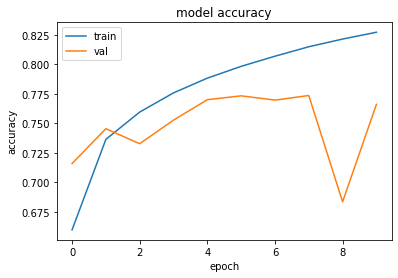

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

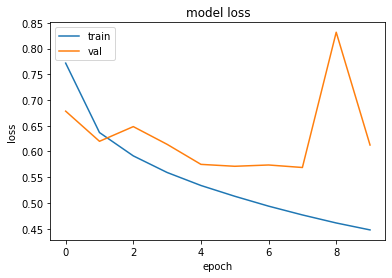

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()